In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
api_calls_day = pd.Timestamp('2019-06-13')
churn_cutoff = api_calls_day - pd.Timedelta(3,'M')

In [3]:
df_friend_summary = pd.read_csv('100k_friend_summary.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_profile_summary = pd.read_csv('100k_clean_player_info.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_per_game_summary = pd.read_csv('100k_per_game.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_game_per_user_summary = pd.read_csv('100k_game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')
df_top5game_per_user_summary = pd.read_csv('100k_top5game_per_user.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [4]:
df_full_prof = df_friend_summary.merge(df_profile_summary,on='steamid',how='right')

In [5]:
df_full_prof = df_full_prof.drop(['lastlogoff_readable','timecreated_readable','newest_friend_steamid', 'oldest_friend_steamid', 'Root', 'First_tier', 'Second_tier', 'Third_tier','realname', 'personaname', 'loccityid', 'loccountrycode', 'locstatecode'],axis='columns')

In [6]:
df_full_prof = df_full_prof.merge(df_game_per_user_summary,on='steamid',how='left')

In [7]:
df_full_prof.fillna(0,inplace=True)

In [8]:
print(churn_cutoff)

2019-03-13 16:32:42


In [9]:
df_full_prof['isChurned'] = df_full_prof['lastlogoff'].map(lambda x: 1 if (pd.to_datetime(x, unit='s') < churn_cutoff) else 0)


In [10]:
df_friend_full = pd.read_csv('player_friend_info_100k.csv',dtype={'steamid': int}).drop('Unnamed: 0',axis='columns')

In [11]:
df_friend_full = df_friend_full[pd.to_datetime(df_friend_full['friend_since'], unit='s') < churn_cutoff]

In [12]:
df_friend_large = pd.merge(df_friend_full,df_full_prof,on='steamid')

In [13]:
df_friend_large = df_friend_large.drop(['relationship','friend_since','newest_friend_time','oldest_friend_time','lastlogoff','profilestate','timecreated','isPublic','isFriendsOnly','isPrivate','playtime_forever_max','playtime_forever_std','playtime_forever_std_noZero'],axis='columns')


In [14]:
df_friends_list = pd.DataFrame(df_friend_large.groupby('steamid_orig')['steamid'].apply(list))

In [15]:
df_friends_list = df_friends_list.add_suffix('_friend_list')
df_friends_list = df_friends_list.reset_index()
df_friends_list['steamid'] = df_friends_list['steamid_orig']
df_friends_list = df_friends_list.drop('steamid_orig',axis='columns')

In [16]:
df_friends_mean = pd.DataFrame(df_friend_large.drop(['steamid','appid_max'],axis='columns').groupby('steamid_orig').mean())

In [17]:
df_friends_mean = df_friends_mean.add_suffix('_friends_mean')

In [18]:
df_friends_mean = df_friends_mean.reset_index()
df_friends_mean['steamid'] = df_friends_mean['steamid_orig']
df_friends_mean = df_friends_mean.drop('steamid_orig',axis='columns')

In [19]:
df_friends_mode = pd.DataFrame(df_friend_large[df_friend_large['appid_max'] != 0].groupby('steamid_orig')['appid_max'].apply(pd.Series.mode))

In [20]:
df_friends_mode = df_friends_mode.reset_index().drop('level_1',axis='columns')
df_friends_mode['steamid'] = df_friends_mode['steamid_orig']
df_friends_mode['friends_fav_appid'] = df_friends_mode['appid_max']
df_friends_mode = df_friends_mode.drop('steamid_orig',axis='columns')
df_friends_mode = df_friends_mode.drop('appid_max',axis='columns')
df_friends_mode = df_friends_mode.drop_duplicates(['steamid'],keep='first')
df_friends_mode.info()
print(df_friends_mode['steamid'].nunique())
print(df_friends_mean['steamid'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65214 entries, 0 to 105551
Data columns (total 2 columns):
steamid              65214 non-null int64
friends_fav_appid    65214 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB
65214
84637


In [21]:
df_friends_stats = pd.merge(df_friends_mean,df_friends_mode,on='steamid',how='outer')

In [22]:
df_friends_temp = df_full_prof.merge(df_friends_stats,on='steamid',how='left')

In [23]:
df_friends_temp['steamid'].nunique()

88555

In [24]:
df_dup_steamid = df_friends_temp[df_friends_temp.duplicated(['steamid'],keep=False)]

In [25]:
df_dup_steamid

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,commentpermission_friends_mean,costom_avatar_friends_mean,inClan_friends_mean,playtime_forever_sum_friends_mean,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid


In [26]:
df_friends_temp.fillna(0,inplace=True)

In [27]:
df_friends_temp['Same_fav_as_friend'] = df_friends_temp.apply(lambda x: 1 if x['appid_max'] == x['friends_fav_appid'] else 0,axis=1)

In [28]:
df_friends_temp['num_Zero_games'] = df_friends_temp['appid_count'] - df_friends_temp['appid_count_noZero']

In [29]:
df_full_prof = df_friends_temp

In [30]:
df_churned = df_full_prof[df_full_prof['isChurned'] == 1]

In [31]:
df_active = df_full_prof[df_full_prof['isChurned'] == 0]

In [32]:
from sklearn.model_selection import train_test_split
df_churned_train, df_churned_test = train_test_split(df_churned,test_size=0.2,random_state=1234)

In [33]:
df_active_remain, df_active_test = train_test_split(df_active,test_size=0.2,random_state=1234)

In [34]:
df_active_extra, df_active_train = train_test_split(df_active_remain,test_size=len(df_churned_train),random_state=1234)

In [35]:
df_train = pd.concat([df_active_train,df_churned_train])

In [36]:
df_test = pd.concat([df_active_test,df_churned_test])

In [37]:
X_train = df_train.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
X_test = df_test.drop(['steamid','isPublic','isFriendsOnly','isPrivate','inClan','appid_count','playtime_forever_mean','lastlogoff','isChurned','appid_max','commentpermission_friends_mean','appid_count_friends_mean','friends_fav_appid','playtime_forever_mean_friends_mean','isChurned_friends_mean','inClan_friends_mean'],axis='columns')
y_train = df_train['isChurned']
y_test = df_test['isChurned']

In [38]:
X_train.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [40]:
log_model = LogisticRegression(random_state=10,solver='lbfgs')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [41]:
log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate on Training Data (Equalized Population Ratio)

[[7295 3775]
 [2324 8746]]


              precision    recall  f1-score   support

           0       0.76      0.66      0.71     11070
           1       0.70      0.79      0.74     11070

   micro avg       0.72      0.72      0.72     22140
   macro avg       0.73      0.72      0.72     22140
weighted avg       0.73      0.72      0.72     22140



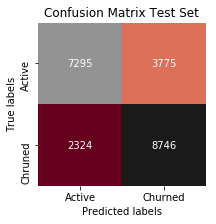

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_train_scaled)
cm = confusion_matrix(y_train,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train,log_pred))

In [43]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_train_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_train['Prob_Active_Log'] = prob_class_active
df_train['Prob_Churned_Log'] = prob_class_churned

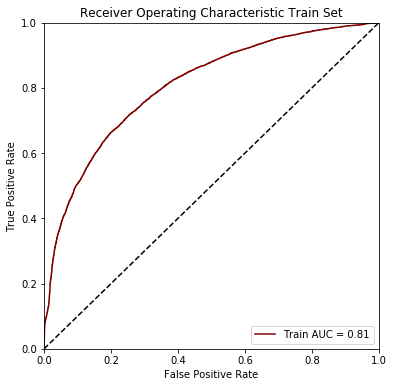

In [44]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_train, df_train['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic Train Set')
plt.plot(fpr, tpr, 'maroon',label = 'Train AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

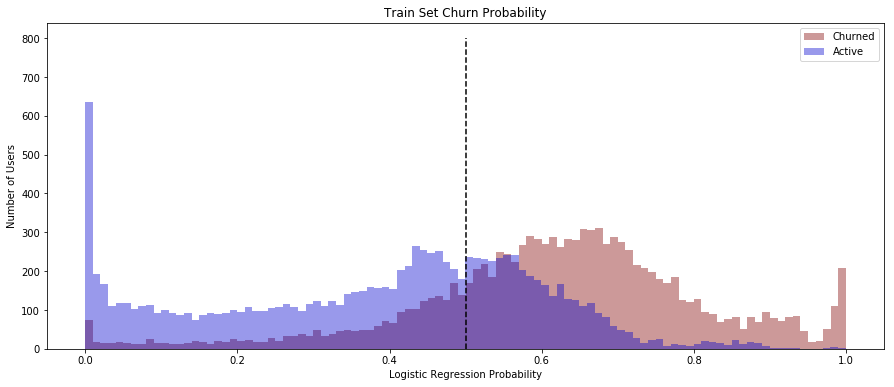

In [45]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train['Prob_Churned_Log'][df_train['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

# Validate on Test Data (True Population Ratio)

[[9689 5255]
 [ 591 2177]]


              precision    recall  f1-score   support

           0       0.94      0.65      0.77     14944
           1       0.29      0.79      0.43      2768

   micro avg       0.67      0.67      0.67     17712
   macro avg       0.62      0.72      0.60     17712
weighted avg       0.84      0.67      0.71     17712



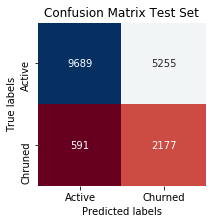

In [46]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_test_scaled)
cm = confusion_matrix(y_test,log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test,log_pred))

In [47]:
prob_class_active = []
prob_class_churned = []
for x in log_model.predict_proba(X_test_scaled):
    prob_class_active.append(x[0])
    prob_class_churned.append(x[1])
df_test['Prob_Active_Log'] = prob_class_active
df_test['Prob_Churned_Log'] = prob_class_churned

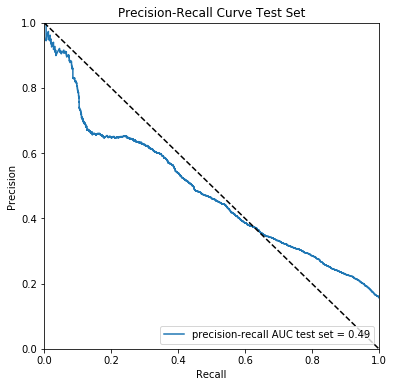

In [48]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, df_test['Prob_Churned_Log'], pos_label=1)
roc_auc = metrics.auc(recall, precision)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve Test Set')
plt.plot(recall, precision, label = 'precision-recall AUC test set = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Calculate Average Prob of Friends

In [49]:
df_friend_full.head()

,friend_since,relationship,steamid,steamid_orig
0,1434524498,friend,76561198007070703,76561198199710782
1,1437740667,friend,76561198041503217,76561198199710782
2,1438264541,friend,76561198238259518,76561198199710782
3,1421677696,friend,76561197960448312,76561198049785932
4,1490267324,friend,76561197961426758,76561198049785932


In [50]:
X_full_scaled = scaler.transform(df_full_prof[['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'playtime_forever_sum', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'costom_avatar_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games']])
df_full_prof['Prob_Churned'] = log_model.predict_proba(X_full_scaled)[:,1]

/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


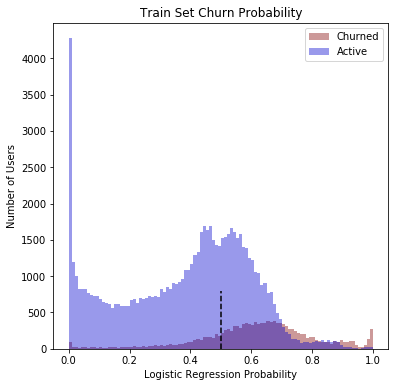

In [51]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_full_prof['Prob_Churned'][df_full_prof['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Train Set Churn Probability")
plt.show()

[[48870 25847]
 [ 2915 10923]]


              precision    recall  f1-score   support

           0       0.94      0.65      0.77     74717
           1       0.30      0.79      0.43     13838

   micro avg       0.68      0.68      0.68     88555
   macro avg       0.62      0.72      0.60     88555
weighted avg       0.84      0.68      0.72     88555



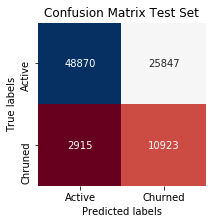

In [52]:
axis = plt.figure(figsize=(3,3))
log_pred = log_model.predict(X_full_scaled)
cm = confusion_matrix(df_full_prof['isChurned'],log_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdBu',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Test Set')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(df_full_prof['isChurned'],log_pred))

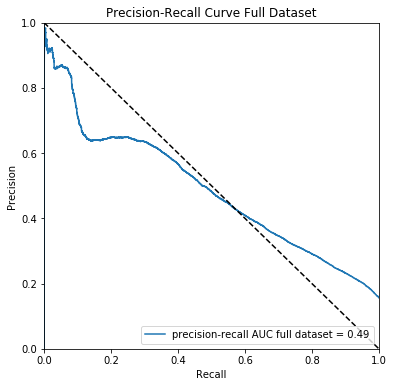

In [53]:
precision, recall, threshold = metrics.precision_recall_curve(df_full_prof['isChurned'], df_full_prof['Prob_Churned'], pos_label=1)
roc_auc = metrics.auc(recall, precision)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve Full Dataset')
plt.plot(recall, precision, label = 'precision-recall AUC full dataset = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [54]:
df_friend_prob = pd.merge(df_friend_full,df_full_prof[['steamid','Prob_Churned']],on='steamid')

In [55]:
df_friend_prob.head()

,friend_since,relationship,steamid,steamid_orig,Prob_Churned
0,1434524498,friend,76561198007070703,76561198199710782,0.202732
1,1455556043,friend,76561198007070703,76561198119327769,0.202732
2,1488713631,friend,76561198007070703,76561198302636934,0.202732
3,1424045974,friend,76561198007070703,76561198035000472,0.202732
4,1403982908,friend,76561198007070703,76561198022371464,0.202732


In [56]:
df_friend_prob = df_friend_prob.drop(['friend_since','relationship'],axis='columns')

In [57]:
df_friends_prob_mean = pd.DataFrame(df_friend_prob.drop(['steamid'],axis='columns').groupby('steamid_orig').mean())

In [58]:
df_friends_prob_mean.head()

,Prob_Churned
steamid_orig,
76561197960265730,0.376784
76561197960265731,0.381118
76561197960265733,0.383589
76561197960265738,0.433092
76561197960265743,0.498385


In [59]:
df_friends_prob_mean = df_friends_prob_mean.add_suffix('_friends_mean')

In [60]:
df_friends_prob_mean = df_friends_prob_mean.reset_index()
df_friends_prob_mean['steamid'] = df_friends_prob_mean['steamid_orig']
df_friends_prob_mean = df_friends_prob_mean.drop('steamid_orig',axis='columns')

In [61]:
df_friends_prob_mean.head()

,Prob_Churned_friends_mean,steamid
0,0.376784,76561197960265730
1,0.381118,76561197960265731
2,0.383589,76561197960265733
3,0.433092,76561197960265738
4,0.498385,76561197960265743


In [62]:
df_friends_big = df_full_prof.merge(df_friends_prob_mean,on='steamid',how='left')

In [63]:
df_friends_big.head()

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,appid_count_friends_mean,playtime_forever_mean_friends_mean,appid_count_noZero_friends_mean,playtime_forever_mean_noZero_friends_mean,isChurned_friends_mean,friends_fav_appid,Same_fav_as_friend,num_Zero_games,Prob_Churned,Prob_Churned_friends_mean
0,9.0,76561197960265730,1.455907e+09,1.347314e+09,0.0,1.560120e+09,1.0,1.063193e+09,1,1,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,1,0.0,0.734668,0.376784
1,174.0,76561197960265731,1.534047e+09,0.000000e+00,1.0,1.560203e+09,1.0,1.063192e+09,1,1,...,83.059524,24.914479,27.642857,67.770969,0.119048,72850.0,0,0.0,0.359305,0.381118
2,70.0,76561197960265733,1.498068e+09,0.000000e+00,0.0,1.547593e+09,1.0,1.063193e+09,1,1,...,78.785714,16.414644,40.309524,36.069376,0.095238,578080.0,0,0.0,0.501581,0.383589
3,91.0,76561197960265738,1.548740e+09,0.000000e+00,1.0,1.559372e+09,1.0,1.063233e+09,1,1,...,102.134328,42.687874,42.447761,101.412194,0.253731,72850.0,0,0.0,0.387407,0.433092
4,66.0,76561197960265743,1.534368e+09,0.000000e+00,0.0,1.557252e+09,1.0,1.063236e+09,1,1,...,95.062500,34.489156,48.750000,72.782834,0.291667,578080.0,0,0.0,0.230164,0.498385


In [64]:
df_friends_big[['isChurned_friends_mean','Prob_Churned_friends_mean','isChurned','Prob_Churned']].corr()

,isChurned_friends_mean,Prob_Churned_friends_mean,isChurned,Prob_Churned
isChurned_friends_mean,1.000000,0.358336,0.151958,0.145250
Prob_Churned_friends_mean,0.358336,1.000000,0.103653,0.252655
isChurned,0.151958,0.103653,1.000000,0.377751
Prob_Churned,0.145250,0.252655,0.377751,1.000000


In [65]:
for i in range(0,len(log_model.coef_[0])):
    print([X_train.columns[i],(abs(log_model.coef_[0][i]))])

['num_Friends', 0.4816571694112387]
['newest_friend_time', 1.0729437261923047]
['oldest_friend_time', 0.16041750082308695]
['commentpermission', 0.05720677115032589]
['profilestate', 0.20911747889607307]
['timecreated', 0.027717481129342615]
['costom_avatar', 0.27316079649090297]
['playtime_forever_sum', 0.2943646777211425]
['playtime_forever_std', 0.07027244873678506]
['playtime_forever_max', 0.9958038070292844]
['appid_count_noZero', 1.0747266859422286]
['playtime_forever_mean_noZero', 0.1217148791278269]
['playtime_forever_std_noZero', 0.0448743764735227]
['num_Friends_friends_mean', 0.08058732359263483]
['costom_avatar_friends_mean', 1.188819814274212]
['playtime_forever_sum_friends_mean', 0.018848389345067187]
['appid_count_noZero_friends_mean', 0.016254987074883376]
['playtime_forever_mean_noZero_friends_mean', 0.0165191879640523]
['Same_fav_as_friend', 0.12012278135482751]
['num_Zero_games', 0.03951858814240962]


In [66]:
df_friends_big['Add_Friend'] = df_friends_big['Prob_Churned']+0

In [67]:
df_friends_big['Play_owned_game'] = df_friends_big['Prob_Churned']+0

In [68]:
df_friends_big['Get_new_game'] = df_friends_big['Prob_Churned']+0

In [69]:
df_friends_big['Get_and_play_new_game'] = df_friends_big['Prob_Churned']+0

In [70]:
df_friends_big['Set_community_profile'] = df_friends_big['Prob_Churned']+0

In [71]:
df_friends_big['Play_friends_game'] = df_friends_big['Prob_Churned']+0

In [72]:
df_friends_big.head()

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,Same_fav_as_friend,num_Zero_games,Prob_Churned,Prob_Churned_friends_mean,Add_Friend,Play_owned_game,Get_new_game,Get_and_play_new_game,Set_community_profile,Play_friends_game
0,9.0,76561197960265730,1.455907e+09,1.347314e+09,0.0,1.560120e+09,1.0,1.063193e+09,1,1,...,1,0.0,0.734668,0.376784,0.734668,0.734668,0.734668,0.734668,0.734668,0.734668
1,174.0,76561197960265731,1.534047e+09,0.000000e+00,1.0,1.560203e+09,1.0,1.063192e+09,1,1,...,0,0.0,0.359305,0.381118,0.359305,0.359305,0.359305,0.359305,0.359305,0.359305
2,70.0,76561197960265733,1.498068e+09,0.000000e+00,0.0,1.547593e+09,1.0,1.063193e+09,1,1,...,0,0.0,0.501581,0.383589,0.501581,0.501581,0.501581,0.501581,0.501581,0.501581
3,91.0,76561197960265738,1.548740e+09,0.000000e+00,1.0,1.559372e+09,1.0,1.063233e+09,1,1,...,0,0.0,0.387407,0.433092,0.387407,0.387407,0.387407,0.387407,0.387407,0.387407
4,66.0,76561197960265743,1.534368e+09,0.000000e+00,0.0,1.557252e+09,1.0,1.063236e+09,1,1,...,0,0.0,0.230164,0.498385,0.230164,0.230164,0.230164,0.230164,0.230164,0.230164


In [73]:
df_friends_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88555 entries, 0 to 88554
Data columns (total 44 columns):
num_Friends                                  88555 non-null float64
steamid                                      88555 non-null int64
newest_friend_time                           88555 non-null float64
oldest_friend_time                           88555 non-null float64
commentpermission                            88555 non-null float64
lastlogoff                                   88555 non-null float64
profilestate                                 88555 non-null float64
timecreated                                  88555 non-null float64
costom_avatar                                88555 non-null int64
isPublic                                     88555 non-null int64
isFriendsOnly                                88555 non-null int64
isPrivate                                    88555 non-null int64
inClan                                       88555 non-null int64
playtime_forever_su

In [74]:
df_friends_small = df_friends_big[['steamid','Prob_Churned', 'Prob_Churned_friends_mean', 'Add_Friend', 'Play_owned_game', 'Get_new_game', 'Get_and_play_new_game', 'Set_community_profile', 'Play_friends_game']]

In [75]:
as_dict = df_friends_small.set_index('steamid').to_dict()

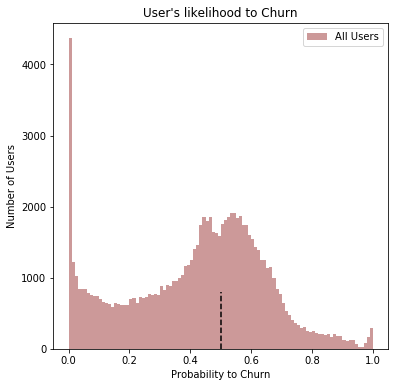

In [76]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [77]:
df_friends_big.loc[df_friends_big['steamid'] == 76561197960265730,'Prob_Churned'].to_list()[0]

0.7346682806369971

In [78]:
n = 0

In [79]:
import json
json = json.dumps(as_dict)
f = open("SteamChurn.json","w")
f.write(json)
f.close()

In [80]:
as_dict.keys()

dict_keys(['Prob_Churned', 'Prob_Churned_friends_mean', 'Add_Friend', 'Play_owned_game', 'Get_new_game', 'Get_and_play_new_game', 'Set_community_profile', 'Play_friends_game'])

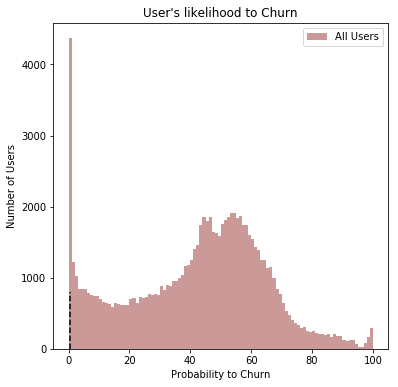

In [81]:
axis = plt.figure(figsize=(6,6))
sns.distplot( list(map(lambda x: x*100, list(as_dict.get('Prob_Churned').values()))) , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 800],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [82]:
list(as_dict.get('Prob_Churned').values())

[0.7346682806369971,
 0.35930483896008797,
 0.5015807118649984,
 0.3874073502230727,
 0.23016364868692998,
 0.39012033663354845,
 0.3148914991403168,
 0.46691635665599784,
 0.3667200072247605,
 0.7035616634132318,
 0.48937515051782415,
 0.43362553729567055,
 0.1231416010745759,
 0.20251341322250552,
 0.1797695609274713,
 0.3914282697662591,
 0.4838818867196917,
 0.4864480502586425,
 0.25124843157641497,
 0.48817505506427966,
 0.40732470472167553,
 0.31147781675741326,
 0.30026604009131713,
 0.5041212069115529,
 0.6431178501883688,
 0.0113371346002937,
 0.6486744566109136,
 0.537955124679067,
 0.519093466760615,
 0.05515084207734277,
 0.4983396288625266,
 0.5684999584637599,
 0.45052204014845265,
 0.3904810519562757,
 0.4549296707750762,
 0.39815439382288753,
 0.6073140134058194,
 0.5574791571335886,
 0.5282990828960067,
 0.4574750885683781,
 0.32098536803767125,
 0.613293452453363,
 0.0003340082733001243,
 0.3764422507469704,
 0.532977561158066,
 0.4583897144337544,
 0.3492342923344047

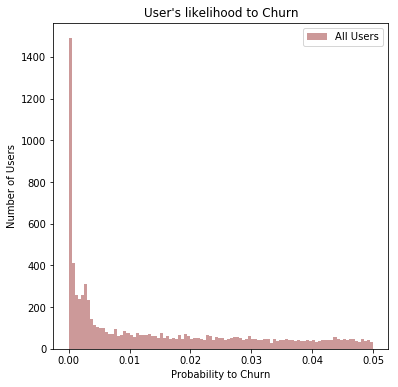

In [83]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['Prob_Churned'] < 0.05] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [84]:
df_friends_big[df_friends_big['Prob_Churned'] < 0.05]

,num_Friends,steamid,newest_friend_time,oldest_friend_time,commentpermission,lastlogoff,profilestate,timecreated,costom_avatar,isPublic,...,Same_fav_as_friend,num_Zero_games,Prob_Churned,Prob_Churned_friends_mean,Add_Friend,Play_owned_game,Get_new_game,Get_and_play_new_game,Set_community_profile,Play_friends_game
25,527.0,76561197960269245,1.549923e+09,0.000000e+00,1.0,1.560713e+09,1.0,1.063347e+09,1,1,...,1,104.0,1.133713e-02,0.157718,1.133713e-02,1.133713e-02,1.133713e-02,1.133713e-02,1.133713e-02,1.133713e-02
42,420.0,76561197960270340,1.549202e+09,0.000000e+00,0.0,1.559647e+09,1.0,1.063349e+09,1,1,...,0,292.0,3.340083e-04,0.383587,3.340083e-04,3.340083e-04,3.340083e-04,3.340083e-04,3.340083e-04,3.340083e-04
73,68.0,76561197960273222,1.530477e+09,0.000000e+00,0.0,1.560669e+09,1.0,1.063351e+09,1,1,...,0,58.0,4.112866e-02,0.337885,4.112866e-02,4.112866e-02,4.112866e-02,4.112866e-02,4.112866e-02,4.112866e-02
82,283.0,76561197960274467,1.549853e+09,1.373772e+09,1.0,1.560311e+09,1.0,1.063352e+09,1,1,...,0,28.0,5.608809e-03,0.300105,5.608809e-03,5.608809e-03,5.608809e-03,5.608809e-03,5.608809e-03,5.608809e-03
124,144.0,76561197960281090,1.529987e+09,0.000000e+00,0.0,1.560201e+09,1.0,1.063355e+09,1,1,...,0,1457.0,9.575804e-03,0.381230,9.575804e-03,9.575804e-03,9.575804e-03,9.575804e-03,9.575804e-03,9.575804e-03
132,134.0,76561197960282580,1.550949e+09,1.394632e+09,1.0,1.560717e+09,1.0,1.063355e+09,1,1,...,0,274.0,4.377608e-04,NaN,4.377608e-04,4.377608e-04,4.377608e-04,4.377608e-04,4.377608e-04,4.377608e-04
141,112.0,76561197960284353,1.550604e+09,0.000000e+00,1.0,1.560549e+09,1.0,1.063356e+09,1,1,...,1,6002.0,2.031727e-05,0.126468,2.031727e-05,2.031727e-05,2.031727e-05,2.031727e-05,2.031727e-05,2.031727e-05
162,233.0,76561197960293516,1.552010e+09,1.434920e+09,1.0,1.560209e+09,1.0,1.063359e+09,1,1,...,0,11708.0,9.418968e-05,0.125049,9.418968e-05,9.418968e-05,9.418968e-05,9.418968e-05,9.418968e-05,9.418968e-05
164,428.0,76561197960294884,1.551912e+09,0.000000e+00,0.0,1.560174e+09,1.0,1.063360e+09,1,1,...,0,542.0,1.119937e-02,0.272000,1.119937e-02,1.119937e-02,1.119937e-02,1.119937e-02,1.119937e-02,1.119937e-02
166,211.0,76561197960296424,1.549128e+09,0.000000e+00,1.0,1.560122e+09,1.0,1.063360e+09,1,1,...,0,122.0,3.004347e-02,0.316666,3.004347e-02,3.004347e-02,3.004347e-02,3.004347e-02,3.004347e-02,3.004347e-02


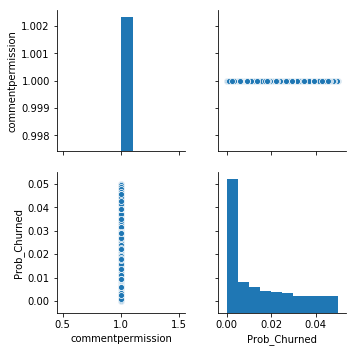

In [85]:
sns.pairplot(data = df_friends_big[(df_friends_big['Prob_Churned'] < 0.05) & (df_friends_big['commentpermission'] == 1)],vars=['commentpermission','Prob_Churned'])

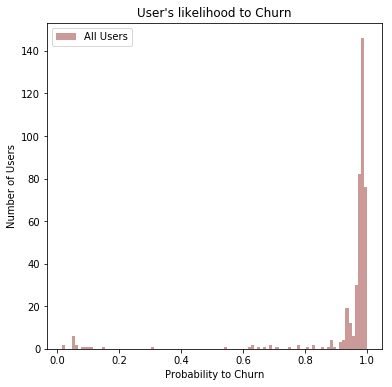

In [86]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['profilestate'] != 1] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

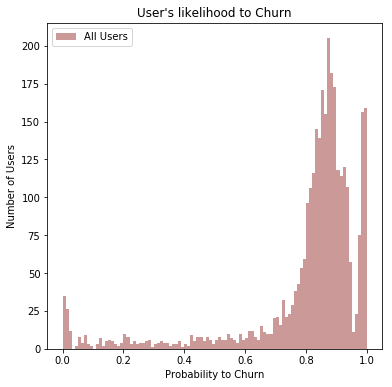

In [87]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['costom_avatar'] == 0] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [88]:
df_friends_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88555 entries, 0 to 88554
Data columns (total 44 columns):
num_Friends                                  88555 non-null float64
steamid                                      88555 non-null int64
newest_friend_time                           88555 non-null float64
oldest_friend_time                           88555 non-null float64
commentpermission                            88555 non-null float64
lastlogoff                                   88555 non-null float64
profilestate                                 88555 non-null float64
timecreated                                  88555 non-null float64
costom_avatar                                88555 non-null int64
isPublic                                     88555 non-null int64
isFriendsOnly                                88555 non-null int64
isPrivate                                    88555 non-null int64
inClan                                       88555 non-null int64
playtime_forever_su

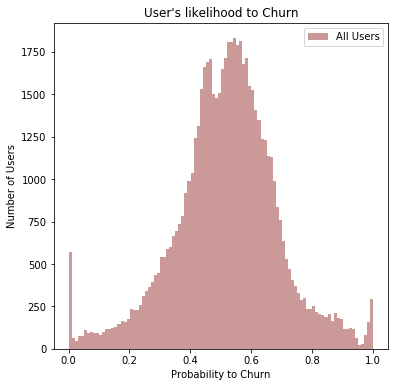

In [89]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['playtime_forever_sum'] == 0] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

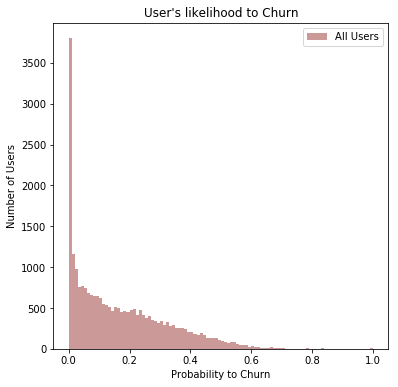

In [90]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][df_friends_big['appid_count'] != 0] , color="maroon", label="All Users",bins=100,kde=False)
plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

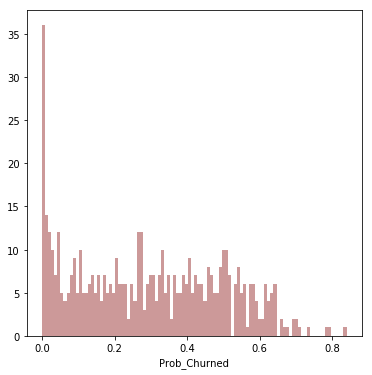

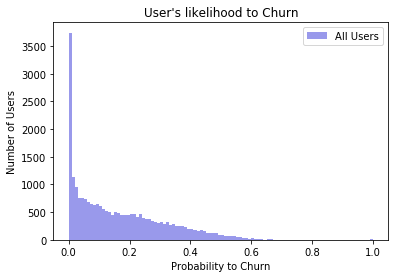

In [91]:
axis = plt.figure(figsize=(6,6))
sns.distplot( df_friends_big['Prob_Churned'][(df_friends_big['num_Zero_games'] != 0) & df_friends_big['isChurned']] , color="maroon", label="All Users",bins=100,kde=False)
plt.show()
sns.distplot( df_friends_big['Prob_Churned'][(df_friends_big['num_Zero_games'] != 0) & ~df_friends_big['isChurned']] , color="mediumblue", label="All Users",bins=100,kde=False)

plt.legend()
plt.ylabel("Number of Users")
plt.xlabel("Probability to Churn")
plt.title("User's likelihood to Churn")
plt.show()

In [92]:
df_churned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13838 entries, 2 to 88378
Data columns (total 36 columns):
num_Friends                                  13838 non-null float64
steamid                                      13838 non-null int64
newest_friend_time                           13838 non-null float64
oldest_friend_time                           13838 non-null float64
commentpermission                            13838 non-null float64
lastlogoff                                   13838 non-null float64
profilestate                                 13838 non-null float64
timecreated                                  13838 non-null float64
costom_avatar                                13838 non-null int64
isPublic                                     13838 non-null int64
isFriendsOnly                                13838 non-null int64
isPrivate                                    13838 non-null int64
inClan                                       13838 non-null int64
playtime_forever_su

In [93]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74717 entries, 0 to 88554
Data columns (total 36 columns):
num_Friends                                  74717 non-null float64
steamid                                      74717 non-null int64
newest_friend_time                           74717 non-null float64
oldest_friend_time                           74717 non-null float64
commentpermission                            74717 non-null float64
lastlogoff                                   74717 non-null float64
profilestate                                 74717 non-null float64
timecreated                                  74717 non-null float64
costom_avatar                                74717 non-null int64
isPublic                                     74717 non-null int64
isFriendsOnly                                74717 non-null int64
isPrivate                                    74717 non-null int64
inClan                                       74717 non-null int64
playtime_forever_su

In [94]:
df_churned_highinfo = df_churned[df_churned['appid_count'] != 0]
df_churned_lowinfo = df_churned[df_churned['appid_count'] == 0]

In [95]:
df_active_highinfo = df_active[df_active['appid_count'] != 0]
df_active_lowinfo = df_active[df_active['appid_count'] == 0]

In [96]:
df_churned_highinfo_train, df_churned_highinfo_test = train_test_split(df_churned_highinfo,test_size=0.2,random_state=1234)
df_churned_lowinfo_train, df_churned_lowinfo_test = train_test_split(df_churned_lowinfo,test_size=0.2,random_state=1234)

In [97]:
df_active_highinfo_remain, df_active_highinfo_test = train_test_split(df_active_highinfo,test_size=0.2,random_state=1234)
df_active_lowinfo_remain, df_active_lowinfo_test = train_test_split(df_active_lowinfo,test_size=0.2,random_state=1234)

In [98]:
df_active_highinfo_extra, df_active_highinfo_train = train_test_split(df_active_highinfo_remain,test_size=len(df_churned_highinfo_train),random_state=1234)
df_actibe_lowinfo_extra, df_active_lowinfo_train = train_test_split(df_active_lowinfo_remain,test_size=len(df_churned_lowinfo_train),random_state=1234)


In [99]:
df_train_highinfo = pd.concat([df_active_highinfo_train,df_churned_highinfo_train])
df_train_lowinfo = pd.concat([df_active_lowinfo_train,df_churned_lowinfo_train])

In [100]:
df_test_highinfo = pd.concat([df_active_highinfo_test,df_churned_highinfo_test])
df_test_lowinfo = pd.concat([df_active_lowinfo_test,df_churned_lowinfo_test])

In [101]:
df_test_highinfo.columns

Index(['num_Friends', 'steamid', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'lastlogoff', 'profilestate', 'timecreated',
       'costom_avatar', 'isPublic', 'isFriendsOnly', 'isPrivate', 'inClan',
       'playtime_forever_sum', 'appid_count', 'playtime_forever_mean',
       'playtime_forever_std', 'appid_max', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'isChurned', 'num_Friends_friends_mean',
       'commentpermission_friends_mean', 'costom_avatar_friends_mean',
       'inClan_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_friends_mean', 'playtime_forever_mean_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'isChurned_friends_mean',
       'friends_fav_appid', 'Same_fav_as_friend', 'num_Zero_games'],
      dtype='object')

In [102]:
len(df_test_highinfo.columns)

36

In [103]:
features_to_drop_highinfo = ['steamid','lastlogoff','isPublic','isFriendsOnly','isPrivate','appid_max','isChurned','friends_fav_appid','isChurned_friends_mean']

In [104]:
df_test_lowinfo.columns

Index(['num_Friends', 'steamid', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'lastlogoff', 'profilestate', 'timecreated',
       'costom_avatar', 'isPublic', 'isFriendsOnly', 'isPrivate', 'inClan',
       'playtime_forever_sum', 'appid_count', 'playtime_forever_mean',
       'playtime_forever_std', 'appid_max', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'isChurned', 'num_Friends_friends_mean',
       'commentpermission_friends_mean', 'costom_avatar_friends_mean',
       'inClan_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_friends_mean', 'playtime_forever_mean_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'isChurned_friends_mean',
       'friends_fav_appid', 'Same_fav_as_friend', 'num_Zero_games'],
      dtype='object')

In [105]:
pd.DataFrame(df_test_lowinfo.describe()).loc['std'] == 0

num_Friends                                  False
steamid                                      False
newest_friend_time                           False
oldest_friend_time                           False
commentpermission                            False
lastlogoff                                   False
profilestate                                 False
timecreated                                  False
costom_avatar                                False
isPublic                                      True
isFriendsOnly                                 True
isPrivate                                     True
inClan                                        True
playtime_forever_sum                          True
appid_count                                   True
playtime_forever_mean                         True
playtime_forever_std                          True
appid_max                                     True
playtime_forever_max                          True
appid_count_noZero             

In [106]:
features_to_drop_lowinfo = ['steamid','lastlogoff','isChurned','isChurned_friends_mean','friends_fav_appid','num_Zero_games','playtime_forever_std_noZero','playtime_forever_mean_noZero','appid_count_noZero','playtime_forever_max','appid_max','playtime_forever_std','playtime_forever_mean','appid_count','playtime_forever_sum','inClan','isPrivate','isFriendsOnly','isPublic']


In [107]:
X_train_highinfo = df_train_highinfo.drop(features_to_drop_highinfo,axis='columns')
X_test_highinfo = df_test_highinfo.drop(features_to_drop_highinfo,axis='columns')
y_train_highinfo = df_train_highinfo['isChurned']
y_test_highinfo = df_test_highinfo['isChurned']

In [108]:
X_train_lowinfo = df_train_lowinfo.drop(features_to_drop_lowinfo,axis='columns')
X_test_lowinfo = df_test_lowinfo.drop(features_to_drop_lowinfo,axis='columns')
y_train_lowinfo = df_train_lowinfo['isChurned']
y_test_lowinfo = df_test_lowinfo['isChurned']

In [109]:
X_train_highinfo.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'inClan', 'playtime_forever_sum', 'appid_count',
       'playtime_forever_mean', 'playtime_forever_std', 'playtime_forever_max',
       'appid_count_noZero', 'playtime_forever_mean_noZero',
       'playtime_forever_std_noZero', 'num_Friends_friends_mean',
       'commentpermission_friends_mean', 'costom_avatar_friends_mean',
       'inClan_friends_mean', 'playtime_forever_sum_friends_mean',
       'appid_count_friends_mean', 'playtime_forever_mean_friends_mean',
       'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend',
       'num_Zero_games'],
      dtype='object')

In [110]:
X_train_lowinfo.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'num_Friends_friends_mean', 'commentpermission_friends_mean',
       'costom_avatar_friends_mean', 'inClan_friends_mean',
       'playtime_forever_sum_friends_mean', 'appid_count_friends_mean',
       'playtime_forever_mean_friends_mean', 'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend'],
      dtype='object')

In [111]:
X_train_highinfo = X_train_highinfo[X_train_lowinfo.columns]
X_test_highinfo = X_test_highinfo[X_test_lowinfo.columns]

In [112]:
X_train_highinfo.columns

Index(['num_Friends', 'newest_friend_time', 'oldest_friend_time',
       'commentpermission', 'profilestate', 'timecreated', 'costom_avatar',
       'num_Friends_friends_mean', 'commentpermission_friends_mean',
       'costom_avatar_friends_mean', 'inClan_friends_mean',
       'playtime_forever_sum_friends_mean', 'appid_count_friends_mean',
       'playtime_forever_mean_friends_mean', 'appid_count_noZero_friends_mean',
       'playtime_forever_mean_noZero_friends_mean', 'Same_fav_as_friend'],
      dtype='object')

In [113]:
print("High Info: Train: " + str(len(y_train_highinfo)) + " Test: " + str(len(y_test_highinfo)))

High Info: Train: 880 Test: 5016


In [114]:
print("Low Info: Train: " + str(len(y_train_lowinfo)) + " Test: " + str(len(y_test_lowinfo)))

Low Info: Train: 21260 Test: 12696


In [115]:
log_model_highinfo = LogisticRegression(random_state=10,solver='lbfgs')
scaler_highinfo = StandardScaler()
X_train_highinfo_scaled = scaler_highinfo.fit_transform(X_train_highinfo)
X_test_highinfo_scaled = scaler_highinfo.transform(X_test_highinfo)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [116]:
log_model_lowinfo = LogisticRegression(random_state=10,solver='lbfgs')
scaler_lowinfo = StandardScaler()
X_train_lowinfo_scaled = scaler_lowinfo.fit_transform(X_train_lowinfo)
X_test_lowinfo_scaled = scaler_lowinfo.transform(X_test_lowinfo)

/anaconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda2/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [117]:
log_model_highinfo.fit(X_train_highinfo_scaled,y_train_highinfo)
log_model_lowinfo.fit(X_train_lowinfo_scaled,y_train_lowinfo)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

# Validate High info model

[[262 178]
 [131 309]]


              precision    recall  f1-score   support

           0       0.67      0.60      0.63       440
           1       0.63      0.70      0.67       440

   micro avg       0.65      0.65      0.65       880
   macro avg       0.65      0.65      0.65       880
weighted avg       0.65      0.65      0.65       880



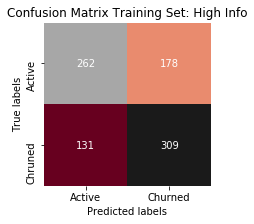

In [118]:
axis = plt.figure(figsize=(3,3))
log_pred_highinfo = log_model_highinfo.predict(X_train_highinfo_scaled)
cm = confusion_matrix(y_train_highinfo,log_pred_highinfo)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Training Set: High Info')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train_highinfo,log_pred_highinfo))

[[2973 1933]
 [  33   77]]


              precision    recall  f1-score   support

           0       0.99      0.61      0.75      4906
           1       0.04      0.70      0.07       110

   micro avg       0.61      0.61      0.61      5016
   macro avg       0.51      0.65      0.41      5016
weighted avg       0.97      0.61      0.74      5016



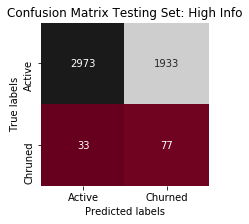

In [119]:
axis = plt.figure(figsize=(3,3))
log_pred_highinfo = log_model_highinfo.predict(X_test_highinfo_scaled)
cm = confusion_matrix(y_test_highinfo,log_pred_highinfo)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Testing Set: High Info')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test_highinfo,log_pred_highinfo))

In [120]:
df_train_highinfo['Prob_Churn'] = log_model_highinfo.predict_proba(X_train_highinfo_scaled)[:,1]
df_test_highinfo['Prob_Churn'] = log_model_highinfo.predict_proba(X_test_highinfo_scaled)[:,1]

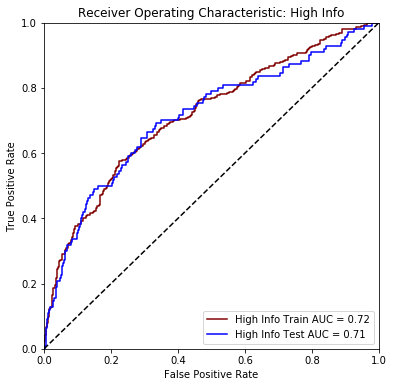

In [121]:
from sklearn import metrics
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_highinfo, df_train_highinfo['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test_highinfo, df_test_highinfo['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic: High Info')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'High Info Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'blue',label = 'High Info Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

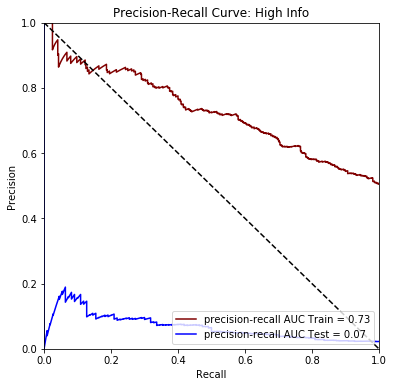

In [122]:
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_highinfo, df_train_highinfo['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(recall_train, precision_train)
precision_test, recall_test, threshold_test = metrics.precision_recall_curve(y_test_highinfo, df_test_highinfo['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(recall_test, precision_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve: High Info')
plt.plot(recall_train, precision_train, 'maroon', label = 'precision-recall AUC Train = %0.2f' % roc_auc_train)
plt.plot(recall_test, precision_test, 'blue', label = 'precision-recall AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

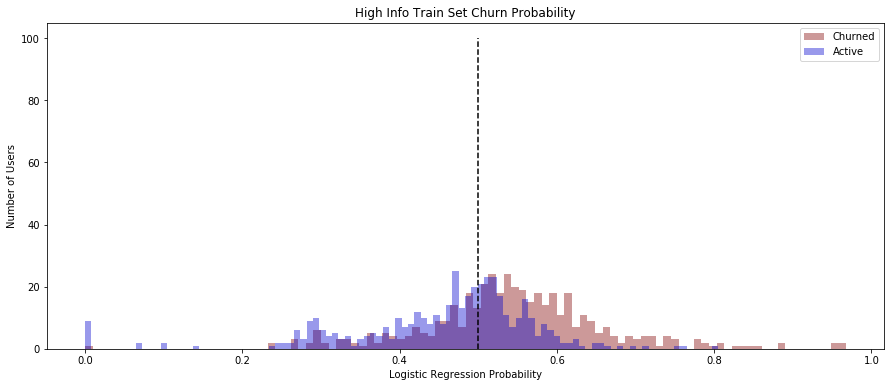

In [123]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_train_highinfo['Prob_Churn'][df_train_highinfo['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train_highinfo['Prob_Churn'][df_train_highinfo['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 100],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("High Info Train Set Churn Probability")
plt.show()

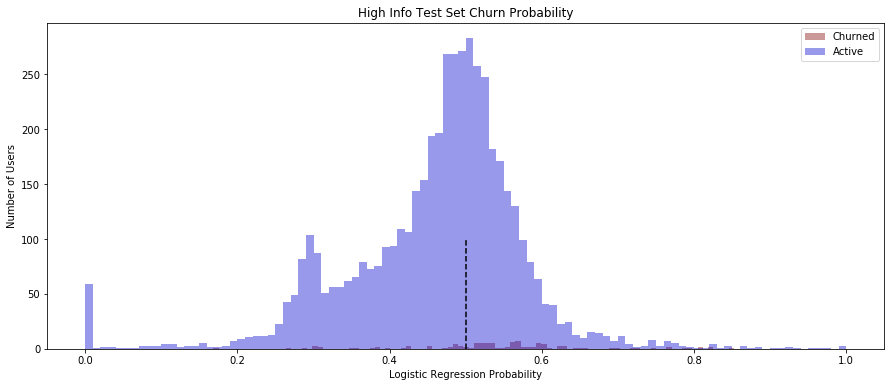

In [124]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_test_highinfo['Prob_Churn'][df_test_highinfo['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_test_highinfo['Prob_Churn'][df_test_highinfo['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 100],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("High Info Test Set Churn Probability")
plt.show()

# Validate Low info model

[[9192 1438]
 [3264 7366]]


              precision    recall  f1-score   support

           0       0.74      0.86      0.80     10630
           1       0.84      0.69      0.76     10630

   micro avg       0.78      0.78      0.78     21260
   macro avg       0.79      0.78      0.78     21260
weighted avg       0.79      0.78      0.78     21260



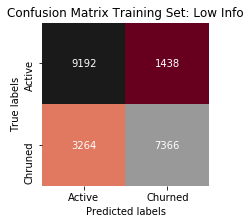

In [125]:
axis = plt.figure(figsize=(3,3))
log_pred_lowinfo = log_model_lowinfo.predict(X_train_lowinfo_scaled)
cm = confusion_matrix(y_train_lowinfo,log_pred_lowinfo)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Training Set: Low Info')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_train_lowinfo,log_pred_lowinfo))

[[8651 1387]
 [ 840 1818]]


              precision    recall  f1-score   support

           0       0.91      0.86      0.89     10038
           1       0.57      0.68      0.62      2658

   micro avg       0.82      0.82      0.82     12696
   macro avg       0.74      0.77      0.75     12696
weighted avg       0.84      0.82      0.83     12696



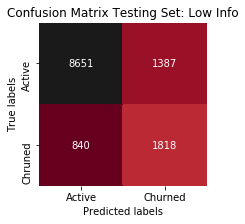

In [126]:
axis = plt.figure(figsize=(3,3))
log_pred_lowinfo = log_model_lowinfo.predict(X_test_lowinfo_scaled)
cm = confusion_matrix(y_test_lowinfo,log_pred_lowinfo)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='d',ax = ax,cmap='RdGy',cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Testing Set: Low Info')
ax.xaxis.set_ticklabels(['Active', 'Churned'])
ax.yaxis.set_ticklabels(['Active', 'Chruned'])
print(cm)
print('\n')
print(classification_report(y_test_lowinfo,log_pred_lowinfo))

In [127]:
df_train_lowinfo['Prob_Churn'] = log_model_lowinfo.predict_proba(X_train_lowinfo_scaled)[:,1]
df_test_lowinfo['Prob_Churn'] = log_model_lowinfo.predict_proba(X_test_lowinfo_scaled)[:,1]

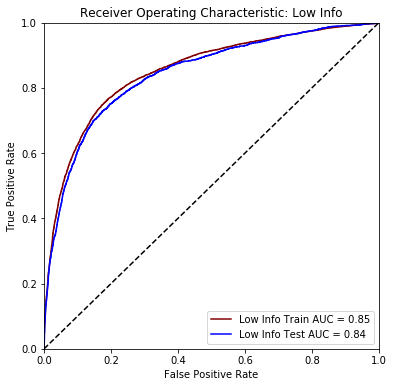

In [128]:
from sklearn import metrics
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train_lowinfo, df_train_lowinfo['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test_lowinfo, df_test_lowinfo['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic: Low Info')
plt.plot(fpr_train, tpr_train, 'maroon',label = 'Low Info Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'blue',label = 'Low Info Test AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

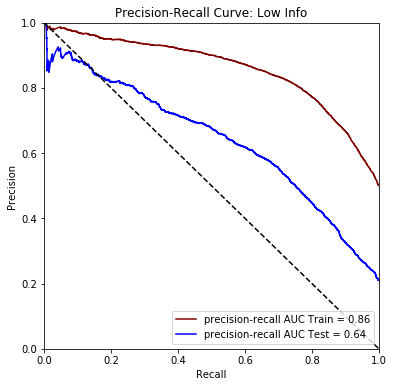

In [129]:
precision_train, recall_train, threshold_train = metrics.precision_recall_curve(y_train_lowinfo, df_train_lowinfo['Prob_Churn'], pos_label=1)
roc_auc_train = metrics.auc(recall_train, precision_train)
precision_test, recall_test, threshold_test = metrics.precision_recall_curve(y_test_lowinfo, df_test_lowinfo['Prob_Churn'], pos_label=1)
roc_auc_test = metrics.auc(recall_test, precision_test)

# method I: plt
axis = plt.figure(figsize=(6,6))
plt.title('Precision-Recall Curve: Low Info')
plt.plot(recall_train, precision_train, 'maroon', label = 'precision-recall AUC Train = %0.2f' % roc_auc_train)
plt.plot(recall_test, precision_test, 'blue', label = 'precision-recall AUC Test = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

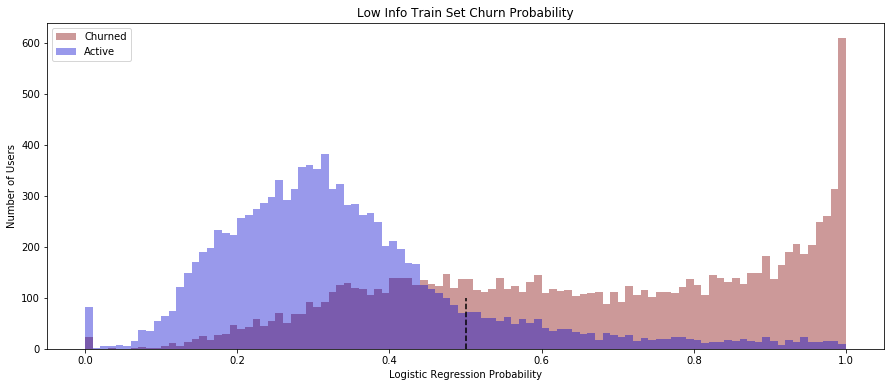

In [130]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_train_lowinfo['Prob_Churn'][df_train_lowinfo['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_train_lowinfo['Prob_Churn'][df_train_lowinfo['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 100],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Low Info Train Set Churn Probability")
plt.show()

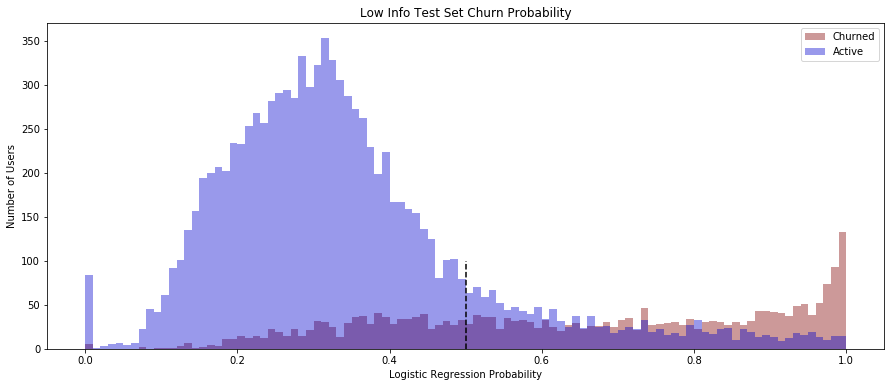

In [131]:
axis = plt.figure(figsize=(15,6))
sns.distplot( df_test_lowinfo['Prob_Churn'][df_test_lowinfo['isChurned'] == 1] , color="maroon", label="Churned",bins=100,kde=False)
sns.distplot( df_test_lowinfo['Prob_Churn'][df_test_lowinfo['isChurned'] == 0] , color="mediumblue", label="Active",bins=100,kde=False)
plt.legend()
plt.plot([0.5, 0.5], [0, 100],'k--')
plt.ylabel("Number of Users")
plt.xlabel("Logistic Regression Probability")
plt.title("Low Info Test Set Churn Probability")
plt.show()

In [132]:
for i in range(0,len(log_model_highinfo.coef_[0])):
    print([X_train_highinfo.columns[i],(abs(log_model_highinfo.coef_[0][i]))])

['num_Friends', 0.2551376382362305]
['newest_friend_time', 2.3973008635098485]
['oldest_friend_time', 0.15994746225960335]
['commentpermission', 0.00195458466771439]
['profilestate', 0.0]
['timecreated', 0.05961355772750012]
['costom_avatar', 0.12564969275837512]
['num_Friends_friends_mean', 0.028993194142768717]
['commentpermission_friends_mean', 0.009964607640703161]
['costom_avatar_friends_mean', 0.7489147655601216]
['inClan_friends_mean', 2.1249134245713845]
['playtime_forever_sum_friends_mean', 0.024669757709820505]
['appid_count_friends_mean', 0.1379313893343744]
['playtime_forever_mean_friends_mean', 0.4606007179472097]
['appid_count_noZero_friends_mean', 0.1512318436684905]
['playtime_forever_mean_noZero_friends_mean', 0.44882137737072125]
['Same_fav_as_friend', 0.07150095603146839]


In [133]:
for i in range(0,len(log_model_lowinfo.coef_[0])):
    print([X_train_lowinfo.columns[i],(abs(log_model_lowinfo.coef_[0][i]))])

['num_Friends', 0.19247318266942862]
['newest_friend_time', 5.79033076404951]
['oldest_friend_time', 0.06176361681912705]
['commentpermission', 0.05872917454396599]
['profilestate', 0.10101960521507056]
['timecreated', 0.3209945848950012]
['costom_avatar', 0.08094791124814724]
['num_Friends_friends_mean', 0.026527596335778954]
['commentpermission_friends_mean', 0.045901903880838146]
['costom_avatar_friends_mean', 0.08141089497196233]
['inClan_friends_mean', 5.3925167597136685]
['playtime_forever_sum_friends_mean', 0.03542132741485986]
['appid_count_friends_mean', 0.09644293432326866]
['playtime_forever_mean_friends_mean', 0.014956261632935139]
['appid_count_noZero_friends_mean', 0.05112823319316239]
['playtime_forever_mean_noZero_friends_mean', 0.017939162004950736]
['Same_fav_as_friend', 0.08002814759746825]
